In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [75]:
TRAINING_DIR = "data_1/train"
VALIDATION_DIR = "data_1/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    #validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=16,
                                                    target_size=(150, 150))

Found 5187 images belonging to 40 classes.


In [76]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        batch_size=16,
                                                        target_size=(150, 150))


Found 1362 images belonging to 40 classes.


In [77]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


In [78]:
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(40, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_10[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']     

In [79]:
int_lr = 1e-4
num_epochs = 100

optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [80]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9 and logs.get('accuracy')>0.9):
      print('accuracy and validation accuracy reach 90%')
      self.model.stop_training = True

mycallback = myCallback()

In [81]:
from sklearn.utils import class_weight
import numpy as np

class_indices = train_generator.class_indices
class_counts = np.bincount(train_generator.classes)

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)

class_weights_dict = {i: class_weights[1] for i in range(len(class_weights))}


In [82]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              #class_weight=class_weights_dict,
              callbacks=mycallback)


Epoch 1/100
325/325 [==============================] - 105s 304ms/step - loss: 3.9001 - accuracy: 0.2851 - val_loss: 2.1670 - val_accuracy: 0.4816
Epoch 2/100
325/325 [==============================] - 96s 295ms/step - loss: 2.4641 - accuracy: 0.4856 - val_loss: 2.0363 - val_accuracy: 0.5536
Epoch 3/100
325/325 [==============================] - 96s 295ms/step - loss: 2.0707 - accuracy: 0.5512 - val_loss: 2.0652 - val_accuracy: 0.5705
Epoch 4/100
325/325 [==============================] - 95s 293ms/step - loss: 1.7465 - accuracy: 0.6063 - val_loss: 1.9048 - val_accuracy: 0.5822
Epoch 5/100
325/325 [==============================] - 94s 290ms/step - loss: 1.5456 - accuracy: 0.6449 - val_loss: 2.2337 - val_accuracy: 0.5698
Epoch 6/100
325/325 [==============================] - 95s 291ms/step - loss: 1.3958 - accuracy: 0.6709 - val_loss: 2.0078 - val_accuracy: 0.5932
Epoch 7/100
325/325 [==============================] - 94s 290ms/step - loss: 1.2009 - accuracy: 0.7114 - val_loss: 2.0279 

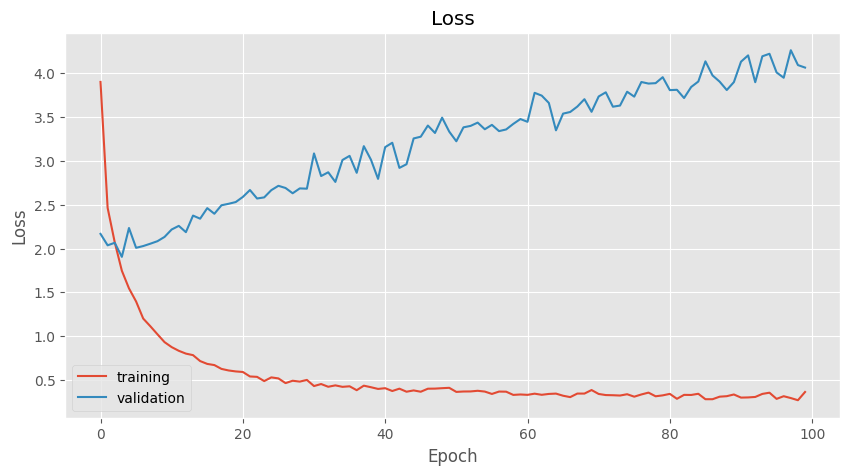

In [83]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


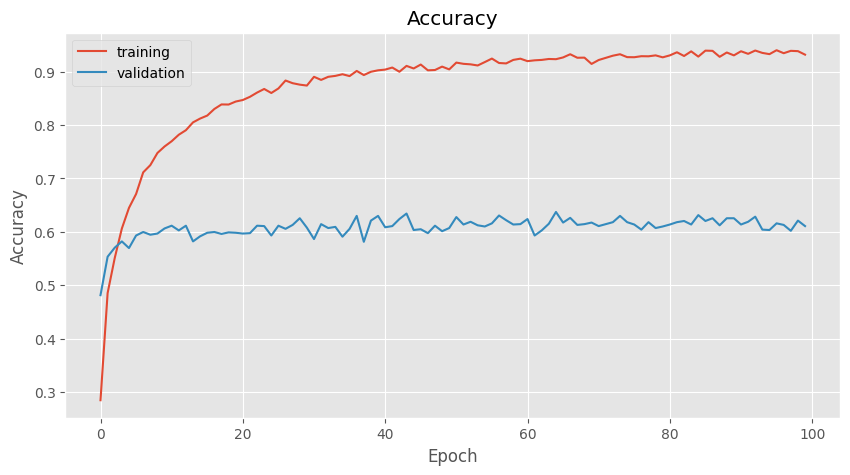

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## save model


In [85]:
model.save_weights('weights/weights_mobilenet-000/weights')

In [86]:
import os
model.save(os.path.join('models/h5', 'explorentt_mobilenet.h5'))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
!tensorflowjs_converter --input_format=keras models/h5/explorentt_mobilenet.h5 models/h5-tfjs


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\converter.py", line 38, in <module>
    from tensorflowjs.converters import tf_saved_model_conversion_v2
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\tf_saved_model_conversion_v2.py", line 2